In [217]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()

In [218]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
from glob import glob
from os import path
from copy import deepcopy
from collections import OrderedDict
from os.path import basename

In [219]:
! ls -ltr ~/des/PearceMCMC/VpeakSHAM_wp_ds*HSAB.hdf5

-rw-r--r-- 1 swmclau2 des  561607404 May  8 05:16 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_wp_ds_rmin_0.5_HSAB.hdf5
-rw-r--r-- 1 swmclau2 des  812402644 May  8 05:43 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_wp_ds_rmin_1.0_HSAB.hdf5
-rw-r--r-- 1 swmclau2 des 1044277221 May  8 06:27 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_wp_ds_rmin_2.0_HSAB.hdf5
-rw-r--r-- 1 swmclau2 des  860703124 May  8 06:27 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_wp_ds_rmin_None_HSAB.hdf5


In [220]:
fnames = sorted(glob('/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_*_HOD.hdf5'))

Assume all chains run with same true values, only thing that differs is the rmin. 

In [221]:
fnames

['/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_0.5_HOD.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_1.0_HOD.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_2.0_HOD.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_None_HOD.hdf5']

In [222]:
if len(fnames)>4:
    _fnames = fnames[:-2]
    _fnames.append(fnames[-1])
    fnames = _fnames

In [223]:
_fnames = []
_fnames.extend(reversed(fnames[:-1]) )
_fnames.append(fnames[-1])
fnames = _fnames

In [224]:
fnames

['/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_2.0_HOD.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_1.0_HOD.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_0.5_HOD.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_None_HOD.hdf5']

In [225]:
model = path.basename(fnames[0]).split('_')[-1].split('.')[0]
#model = path.basename(fnames[0]).split('_')[-2]#.split('.')[0]

In [226]:
model

'HOD'

In [227]:
f = h5py.File(fnames[0], 'r')

In [228]:
f.attrs.keys()

[u'chain_fixed_params',
 u'cov',
 u'dlogz',
 u'emu_cov_fname',
 u'emu_hps',
 u'emu_type',
 u'fixed_params',
 u'mcmc_type',
 u'nburn',
 u'nlive',
 u'nsteps',
 u'nwalkers',
 u'obs',
 u'param_names',
 u'seed',
 u'sim',
 u'training_file',
 u'true_cov_fname',
 u'true_data_fname']

In [229]:
n_walkers = f.attrs['nwalkers']

In [230]:
chain_pnames = list(f.attrs['param_names'])

In [231]:
chain_pnames.extend(['Om', 'S8']) # temporary

In [232]:
#sim_info = eval(f.attrs['sim'])
sim_info = f.attrs['sim']

In [233]:
#gal_type = eval(f.attrs['sim'])['gal_type']
if basename(fnames[0])[:3] == 'HOD' and basename(fnames[0])[4:9] != 'MDPL2':
    gal_type = 'HOD'
else:
    gal_type = 'SHAM'#'HOD'

In [234]:
f.close()

In [235]:
chain_pnames

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'logM1',
 'logM0',
 'sigma_logM',
 'alpha',
 'conc_gal_bias',
 'Om',
 'S8']

In [236]:
param_name_dict = {'ombh2': r'$\Omega_b h^2$', 'omch2': r'$\Omega_c h^2$','w0': r'$w_0$','ns': r'$n_s$', \
                   'sigma8': r'$\sigma_8$', 'ln10As':r'$\ln 10^{10} A_s$', 'H0': r'$H_0$','Neff': r'$N_{eff}$',\
               'mean_occupation_centrals_assembias_corr1': r'$\rho_{cen}$',\
                 'mean_occupation_satellites_assembias_corr1':r'$\rho_{sat}$',\
                   'mean_occupation_centrals_assembias_param1': r'$\mathcal{A}_{cen}$',\
                 'mean_occupation_satellites_assembias_param1':r'$\mathcal{A}_{sat}$',\
                   'mean_occupation_centrals_assembias_slope1': r'$\mathcal{B}_{cen}$',\
                 'mean_occupation_satellites_assembias_slope1':r'$\mathcal{B}_{sat}$',\
                   'logM1': r'$\log(M_1)$','logM0': r'$\log(M_0)$','sigma_logM': r'$\sigma_{\log M }$',
                   'conc_gal_bias': r'$\eta$', 'alpha':r'$\alpha$',
                  'Om': r'$\Omega_m$', 'S8': r'$S_8$'}

In [237]:
bounds_dict = {'H0': (61.69472, 74.76751999999999),
 'Neff': (2.62125, 4.27875),
 'alpha': (0.7, 1.3),
 'conc_gal_bias': (0.5, 2.0),
 'sigma8': (0.65, 1.0), # TODO update
 'logM0': (12.6, 13.6),
 'logM1': (13.7, 14.7),
 'ns': (0.9278462, 0.9974495999999999),
 'ombh2': (0.02066455, 0.02371239),
 'omch2': (0.1012181, 0.13177679999999997),
 'sigma_logM': (0.05, 0.5),
 'ln10As': (3.0, 3.1),
 'w0': (-1.399921, -0.5658486),
 'Om': (0.15, 0.45),
 'S8': (0.6, 1.0),
 'mean_occupation_centrals_assembias_corr1': (-1.0, 1.0),
 'mean_occupation_satellites_assembias_corr1': (-1.0, 1.0),
 'mean_occupation_centrals_assembias_param1': (-1.0, 1.0),
 'mean_occupation_satellites_assembias_param1': (-1.0, 1.0),
 'mean_occupation_centrals_assembias_slope1': (-3.0, 3.0),
 'mean_occupation_satellites_assembias_slope1': (-3.0, 3.0)}

In [238]:
hod_param_names = []
cosmo_param_names = []

hod_bounds = []
cosmo_bounds = []
cosmo_names = set(['ombh2', 'omch2', 'w0', 'ns', 'sigma8', 'H0', 'Neff', 'ln10As', 'Om', 'S8'])
for pname in chain_pnames:
    if pname in cosmo_names:
        cosmo_param_names.append(param_name_dict[pname])
        cosmo_bounds.append(bounds_dict[pname])
    else:
        hod_param_names.append(param_name_dict[pname])
        hod_bounds.append(bounds_dict[pname])
param_names = deepcopy(cosmo_param_names)
param_names.extend(hod_param_names)

bounds = deepcopy(cosmo_bounds)
bounds.extend(hod_bounds)

In [239]:
c = ChainConsumer()

In [240]:
def modify_chain(chain, param_names):
    new_pnames = ['Om', 'S8']
    h = chain[:,param_names.index('H0')]/100
    
    Omc, Omb = chain[:,param_names.index('omch2')]/(h**2), chain[:,param_names.index('ombh2')]/(h**2)
    Om = Omc+Omb
    
    S8 = chain[:,param_names.index('sigma8')]*np.sqrt(Om/0.3)

    new_chain = np.hstack([chain[:,:7], Om.reshape((-1,1)), S8.reshape((-1,1)), chain[:,7:]])
    param_names.insert(7, new_pnames[0])
    param_names.insert(8, new_pnames[1])

    return new_chain, param_names

In [241]:
n_burn = 500
global_chain_pnames = []
global_hod_pnames = []
for fname in fnames:
#for fname in [fnames[0], fnames[3]]:
    try:
        f = h5py.File(fname, 'r')
        chain = f['chain'][n_burn*n_walkers:]
        chain = chain[np.all(chain!=0.0, axis = 1), :]
    except IOError:
        print 'Error loading', fname
        continue
    
    #print chain.shape
    chain = chain.reshape((-1, n_walkers, chain.shape[1]))
    #print chain.shape
    chain = chain.reshape((-1, chain.shape[2]), order = 'F')
    #chain = chain[:, 0, :]
    if chain.shape[0] == 0:
        print 'Insufficient samples in', fname
        continue
    
    #name = path.basename(fname).split('_')[-1].split('.')[0]
    name = path.basename(fname).split('_')[-2]#[4][5]
    #name = path.basename(fname).split('_')[0]
    
    if name == "None":
        name = "0.1"
        
    name = r"$r_{min} = %s$"%name
    
    hod_param_names = []
    cosmo_param_names = []
    chain_pnames = list(f.attrs['param_names'])
    cosmo_names = set(['ombh2', 'omch2', 'w0', 'ns', 'sigma8', 'H0', 'Neff', 'Om', 'S8'])
    
    chain, chain_pnames = modify_chain(chain, chain_pnames)
    
    for pname in chain_pnames:
        if pname in cosmo_names:
            cosmo_param_names.append(param_name_dict[pname])
        else:
            hod_param_names.append(param_name_dict[pname])

    param_names = deepcopy(cosmo_param_names)
    param_names.extend(hod_param_names)
    print fname
    print chain.shape, chain.shape[0]/n_walkers, len(param_names)
    
    
    c.add_chain(chain, parameters=param_names, name = name, walkers = n_walkers)
    f.close()

    for cname in chain_pnames:
        if cname not in global_chain_pnames:
            global_chain_pnames.append(cname)
            
    for cname in hod_param_names:
        if cname not in global_hod_pnames:
            global_hod_pnames.append(cname) 
            
chain_pnames = global_chain_pnames
hod_param_names = global_hod_pnames

/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_2.0_HOD.hdf5
(3152000, 14) 12608 14
/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_1.0_HOD.hdf5
(2858250, 14) 11433 14
Error loading /u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_0.5_HOD.hdf5
Insufficient samples in /u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_None_HOD.hdf5


In [242]:
f.close()

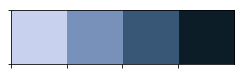

In [243]:
if model == 'HOD':
    #palette = sns.cubehelix_palette(len(fnames), start = 2.6, rot = 0.1, gamma = 0.7)
    palette = sns.cubehelix_palette(len(fnames), start = 2.6, rot = 0.1, gamma = 1.2)

elif model == 'HSAB':
    palette = sns.cubehelix_palette(len(fnames), start = 2.0, rot = 0.1, gamma = 0.7)
    #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.6, gamma = 1.7)
elif model == 'CAB':
    palette = sns.cubehelix_palette(len(fnames), start = 0.6, rot = 0.1, gamma = 1.2)
elif model == 'CorrAB':
    #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 1.2)
    palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 2.0)
else:
    palette = sns.cubehelix_palette(len(fnames), start = 2.6, rot = 0.1, gamma = 1.2)

sns.palplot(palette)

In [244]:
def color_to_hex(color):
    return np.array(color)#*255

In [245]:
c.configure(colors = [color_to_hex(p) for p in palette], shade = True, shade_alpha=0.2, shade_gradient=1.0)
c.configure(diagonal_tick_labels=False, tick_font_size=8, label_font_size=25, \
            max_ticks=8)

In [246]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [247]:
hod_idxs = np.array(range(len(cosmo_param_names), len(cosmo_param_names)+len(hod_param_names)-1)) #skip eta
cosmo_idxs = np.array(range(len(cosmo_param_names)))

In [248]:
cosmo_param_names

['$\\Omega_b h^2$',
 '$\\Omega_c h^2$',
 '$w_0$',
 '$n_s$',
 '$H_0$',
 '$N_{eff}$',
 '$\\sigma_8$',
 '$\\Omega_m$',
 '$S_8$']

In [249]:
hod_param_names

['$\\log(M_1)$',
 '$\\log(M_0)$',
 '$\\sigma_{\\log M }$',
 '$\\alpha$',
 '$\\eta$']

In [250]:
if gal_type == 'HOD':
    from pearce.mocks import cat_dict
    #cosmo_params = {'simname': sim_info['simname'], 'boxno': sim_info['sim_hps']['boxno'],\
    #                'realization': sim_info['sim_hps']['realization'], 'scale_factors':[sim_info['scale_factor']],\
    #                'system': 'ki-ls'}
    cosmo_params = {'simname': 'testbox', 'boxno': 1,\
                    'realization':1, 'scale_factors':[1.0],\
                    'system': 'ki-ls'}
    cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!
    
    cpv = cat._get_cosmo_param_names_vals()

    cat_val_dict =  {key: val for key, val in zip(cpv[0], cpv[1])}
    cosmo_true_vals = [cat_val_dict[pn] for pn in chain_pnames if pn in cat_val_dict]
    
    Om = (cat_val_dict['ombh2']+cat_val_dict['omch2'])/((cat_val_dict['H0']/100)**2)
    S8 = cat_val_dict['sigma8']*np.sqrt(Om/0.3)
    cosmo_true_vals.extend([Om, S8])
    
    hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
    hod_true_vals = [hod_params[key] for key in chain_pnames if key in hod_params]
    
    if model!= 'HOD':
        hod_true_vals.extend([0, 0])
        if model == 'CAB':
            hod_true_vals.extend([0,0])
else: #SHAM, etc on MDPL2
 
    # multidark planck2
    #cosmo_true_vals = np.array([0.0223, 0.1188, -1, 0.9667, 3.047, \
    #                            0.6774*100, 3.046]) #darksky
    
    h = 0.6777
    #cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'Om', 'S8']
    #cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2- 0.048206*h**2,\
    #                            -1, 0.9667, \
    #                            h*100, 3.046, 0.8228, ]) #mdpl2
    cosmo_true_vals = np.array([0.048206*h**2, 0.2589*h**2,\
                                -1, 0.9667, \
                                h*100, 3.046, 0.8228, 0.3089,\
                                0.8228*np.sqrt(0.3089/0.3) ]) #mdpl2
    hod_true_vals = np.array([np.inf for p in hod_param_names])

In [251]:
hod_param_names

['$\\log(M_1)$',
 '$\\log(M_0)$',
 '$\\sigma_{\\log M }$',
 '$\\alpha$',
 '$\\eta$']

In [252]:
# Enforce a consistent order for the plots
#if gal_type == 'HOD':
    
plot_hod_param_names = ['$\\sigma_{\\log M }$', '$\\log(M_0)$', '$\\log(M_1)$', '$\\alpha$', '$\\eta$']
plot_hod_true_vals = [0.2, 13.2, 14.2, 1.083, 1.0]

plot_hod_bounds = [(0.05, 0.5), (12.6, 13.6), (13.7, 14.7), (0.7, 1.3), (0.5, 2.0)]

ab_param_names = [r'$\mathcal{A}_{%s}$', r'$\mathcal{B}_{%s}$', r'$\rho_{%s}$']
ab_true_vals = [0.0, np.inf,0.0]
for abpn, hodtv in zip(ab_param_names, ab_true_vals):
    if abpn%'cen' in hod_param_names: # this pname is in the model
        if 'B' in abpn:
            plot_hod_true_vals.extend([np.inf, np.inf])
            plot_hod_param_names.extend([abpn%'cen', abpn%'sat'])

            continue
        for gal_type in ['cen', 'sat']:
            plot_hod_param_names.append(abpn%gal_type)#

            if gal_type == 'cen':
                plot_hod_true_vals.append(np.inf)#0.0)
            else:
                plot_hod_true_vals.append(np.inf)#0.0)

            plot_hod_bounds.append((-1.0, 1.0))

#for phpn in plot_hod_param_names:
#    i = hod_param_names.index(phpn)
#    print phpn, i, hod_true_vals[i]
#    plot_hod_true_vals.append(hod_true_vals[i])
#    plot_hod_bounds.append(hod_bounds[i])


/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


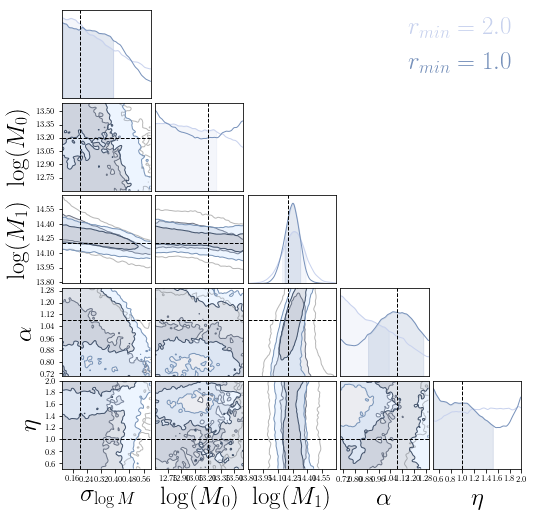

In [260]:
fig = c.plotter.plot(figsize='GROW', parameters = plot_hod_param_names, truth=plot_hod_true_vals)#, extents=hod_bounds) 
#plt.suptitle('HSAB')
fig.show()

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


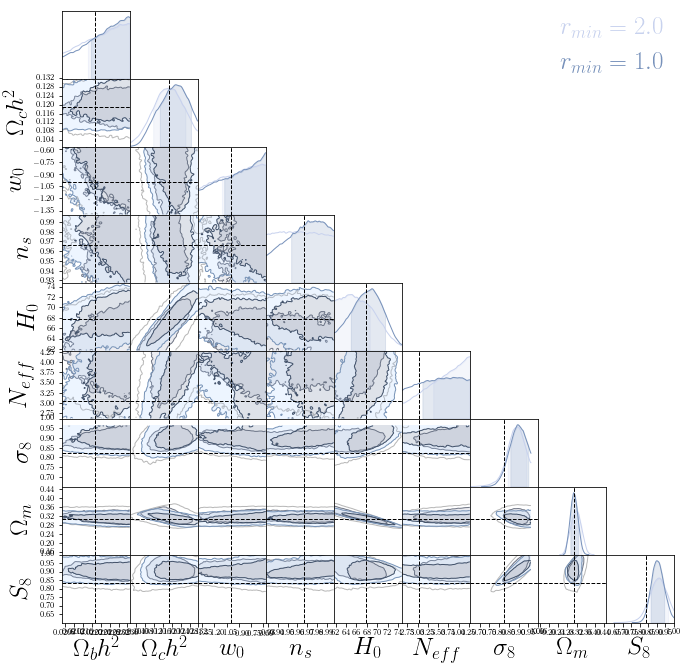

In [261]:
fig = c.plotter.plot(figsize='PAGE', parameters = cosmo_param_names, truth=cosmo_true_vals, extents=cosmo_bounds) 
fig.show()

In [253]:
from copy import deepcopy
true_vals  = list(deepcopy(cosmo_true_vals))
true_vals.extend(plot_hod_true_vals)

In [254]:
plot_param_names = list(deepcopy(cosmo_param_names))
plot_param_names.extend(plot_hod_param_names)

In [255]:
plot_param_bounds = list(deepcopy(cosmo_bounds))
plot_param_bounds.extend(plot_hod_bounds)

In [256]:
plot_param_names

['$\\Omega_b h^2$',
 '$\\Omega_c h^2$',
 '$w_0$',
 '$n_s$',
 '$H_0$',
 '$N_{eff}$',
 '$\\sigma_8$',
 '$\\Omega_m$',
 '$S_8$',
 '$\\sigma_{\\log M }$',
 '$\\log(M_0)$',
 '$\\log(M_1)$',
 '$\\alpha$',
 '$\\eta$']

In [257]:
# TODO can choose these by galaxy model 
# TODO combine multiple chains? 
#summary_idxs = [1, 4]
#summary_idxs = [7,6,8,4,13]
summary_idxs = [7,8,4,13]
if len(plot_param_names) > 14:
    summary_idxs.extend([14,15])#,18,19])
    #summary_idxs.extend([11,12])
    pass


summary_pnames = [plot_param_names[i] for i in summary_idxs]
summary_truths = [true_vals[i] for i in summary_idxs]
#summary_bounds = [plot_param_bounds[i] for i in summary_idxs]

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


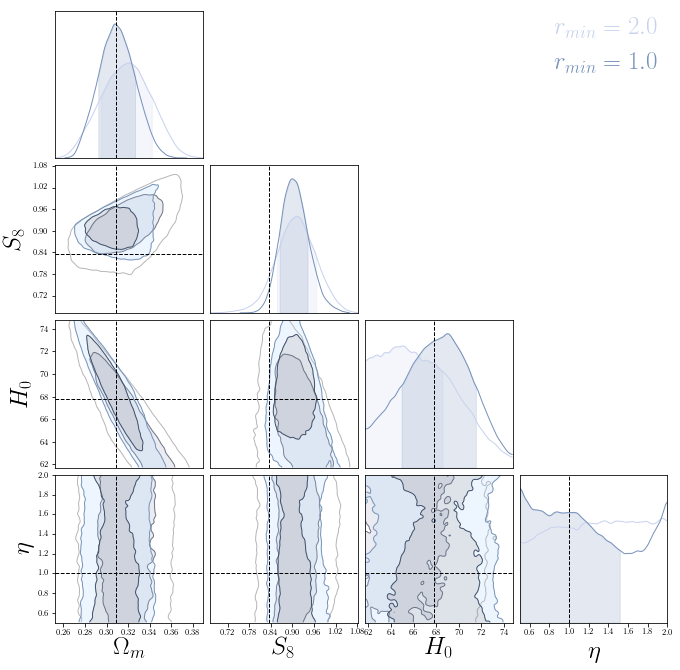

In [258]:
fig = c.plotter.plot(figsize='PAGE', parameters =summary_pnames\
                                    , truth=summary_truths)#, extents=summary_bounds) 
fig.show()

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


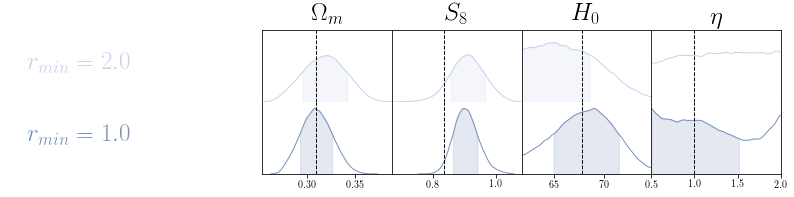

In [259]:
fig = c.plotter.plot_summary(parameters = summary_pnames, truth=summary_truths,\
                             #extents=summary_bounds,\
                             figsize=2, errorbar=False) 
#fig.suptitle(model) # + galtype
fig.show()